In [1]:
import numpy as np
import pandas as pd
import glob
import os
import json
import anndata
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from dredFISH.Utils.__init__plots import *
from dredFISH.Utils import basicu

In [2]:
def normalize_w(W, num_tp=90000):
    """Normalize the matrix W from DPNMF
    - scale 
    - integerize
    - remove genes with no weights
    """
    # scale
    Wn = W/(W.sum().sum())*num_tp
    # integerize 
    Wn = (Wn+0.5).astype(int)
    # remove genes with no weights
    nonzero_cond = Wn.sum(axis=1)>0  
    
    Wn_slim = Wn.loc[nonzero_cond]
    
    print(f"Total num probes: {Wn.sum().sum():,}")
    print(f"Total num genes: {nonzero_cond.sum():,}")
    return Wn, Wn_slim, nonzero_cond

In [3]:
def normalize_w_v2(W, cnstrnts, num_tp=90000):
    """Normalize the matrix W from DPNMF
    - scale 
    - integerize
    - cap probe constraints
    - remove genes with no weights
    
    arguments:
    - W: DataFrame
    """
    assert len(W) == len(cnstrnts)
    
    # scale
    Wn = W/(W.sum().sum())*num_tp
    # integerize 
    Wn = (Wn+0.5).astype(int)
    # constraints
    for col in Wn:
        Wn[col] = np.clip(Wn[col], None, cnstrnts)
    # remove genes with no weights
    nonzero_cond = Wn.sum(axis=1)>0  
    
    Wn_slim = Wn.loc[nonzero_cond]
    
    print(f"Total num probes: {Wn.sum().sum():,}")
    print(f"Total num genes: {nonzero_cond.sum():,}")
    return Wn, Wn_slim, nonzero_cond

In [36]:
def plot_W(Wn_slim, ax, reorder_genes=True, style='v'):
    Wn_slim = np.array(Wn_slim)
    if reorder_genes:
        _mat, _row, _col = basicu.diag_matrix_rows(Wn_slim)
    else:
        _mat = Wn_slim
    m, n = _mat.shape
    
    if style == 'v':
        cbar_kws = dict(shrink=0.5, label='Mean num probes')
    elif style == 'h':
        cbar_kws = dict(shrink=0.8, label='Mean num probes', orientation='horizontal', pad=0.05)

    sns.heatmap(
                pd.DataFrame(_mat), 
                cmap='rocket_r',
                ax=ax, 
                cbar_kws=cbar_kws,
                rasterized=True,
                norm=matplotlib.colors.LogNorm(),
               )
    ax.set_xlabel('Basis')
    ax.set_ylabel('Genes')

    ax.set_xticks([n])
    ax.text(n, m, n, ha='center', va='top')

    ax.set_yticks([m])
    ax.text(0, m, m, ha='right', va='center')
    
    return _mat, _row

def plot_Sc(Sc, ax, style='v', **kwargs):
    """
    """
    m, n = Sc.shape
    
    if style == 'v':
        cbar_kws = dict(shrink=0.5, label='Mean num probes')
    elif style == 'h':
        cbar_kws = dict(shrink=0.8, label='Mean num probes', orientation='horizontal', pad=0.05)
    
    sns.heatmap(Sc, 
                xticklabels=5,
                cmap='coolwarm', 
                norm=matplotlib.colors.LogNorm(),
                cbar_kws=cbar_kws,
                ax=ax,
                **kwargs,
               )
    # ax.set_xticks([n])
    # ax.text(n, m, n, ha='center', va='top')
    
def plot_Scn(Scn, ax, style='v', xticklabels=5, **kwargs):    
    """
    """
    m, n = Scn.shape
    
    if style == 'v':
        cbar_kws = dict(shrink=0.5, label='Zscored mean num probes')
    elif style == 'h':
        cbar_kws = dict(shrink=0.8, label='Zscored mean num probes', orientation='horizontal', pad=0.05)
        
    sns.heatmap(Scn, 
                xticklabels=xticklabels,
                cmap='coolwarm', 
                cbar_kws=cbar_kws,
                center=0,
                vmax=3,
                vmin=-3,
                ax=ax,
                **kwargs,
               )
    # ax.set_xticks([n])
    # ax.text(n, m, n, ha='center', va='top')
    
def plot_all_mats(Wn_slim, Sc, Spc, Scn, Spcn, title=""):
    """
    """
    with sns.axes_style('white'):
        fig, axs = plt.subplots(1, 5, figsize=(6*5,16))
        ax = axs[0]
        plot_W(Wn_slim, ax, style='h')
        ax.set_title(title)

        ax = axs[1]
        plot_Sc(Sc, ax, style='h', yticklabels=False)
        ax.set_title('Z (theory)')
        ax.set_ylabel('Cell types')

        ax = axs[2]
        plot_Sc(Spc, ax, style='h', yticklabels=False)
        ax.set_title('Z (corrected)')

        ax = axs[3]
        plot_Scn(Scn, ax, style='h', yticklabels=False)
        ax.set_title('Z (theory) normed')

        ax = axs[4]
        plot_Scn(Spcn, ax, style='h', yticklabels=l3clst_order)
        ax.set_title('Z (corrected) normed')
        ax.yaxis.tick_right()
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

        fig.subplots_adjust(wspace=0.1)
        plt.show()

In [5]:
ddir = "/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v2"
ddirp = ddir #+"*subL3n100_*mu*"
!ls $ddirp

smrt_X_all_cells.csv
smrt_X_all_y_L3_dpnmfS_k24_mu0.01.csv
smrt_X_all_y_L3_dpnmfS_k24_mu10000.csv
smrt_X_all_y_L3_dpnmfS_k24_mu100.csv
smrt_X_all_y_L3_dpnmfS_k24_mu1.csv
smrt_X_all_y_L3_dpnmfS_k24_mu1e-04.csv
smrt_X_all_y_L3_dpnmfSsel_k24_mu0.01.csv
smrt_X_all_y_L3_dpnmfSsel_k24_mu10000.csv
smrt_X_all_y_L3_dpnmfSsel_k24_mu100.csv
smrt_X_all_y_L3_dpnmfSsel_k24_mu1.csv
smrt_X_all_y_L3_dpnmfSsel_k24_mu1e-04.csv
smrt_X_all_y_L3_dpnmfW_k24_mu0.01.csv
smrt_X_all_y_L3_dpnmfW_k24_mu10000.csv
smrt_X_all_y_L3_dpnmfW_k24_mu100.csv
smrt_X_all_y_L3_dpnmfW_k24_mu1.csv
smrt_X_all_y_L3_dpnmfW_k24_mu1e-04.csv
smrt_X_all_y_L3_dpnmfWsel_k24_mu0.01.csv
smrt_X_all_y_L3_dpnmfWsel_k24_mu10000.csv
smrt_X_all_y_L3_dpnmfWsel_k24_mu100.csv
smrt_X_all_y_L3_dpnmfWsel_k24_mu1.csv
smrt_X_all_y_L3_dpnmfWsel_k24_mu1e-04.csv


# Get data

In [6]:
# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'
with open(meta_path, 'r') as fh:
    meta = json.load(fh)
    
l3clst_order = meta['l3_clsts'] # get cluster order

In [7]:
# read in data
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_count_matrix_v5.h5ad'
adata = anndata.read(f)#, backed='r')

# get the NN genes
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/10X/genes.npy' 
tenx_genes = np.load(f)
nn_genes = tenx_genes

# get gene constraints
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/10X/probe_constraints.npy'
cnstrnts = np.load(f)
assert len(cnstrnts) == len(nn_genes)

In [8]:
# cellcount_bytype
cellcount_bytype = adata.obs.groupby('subclass_label').size().loc[l3clst_order]

In [9]:
# cellcov_bytype
cellcov = adata.X.sum(axis=1)
cellcov = np.array(cellcov).reshape(-1,)
adata.obs['cellcov'] = cellcov
cellcov_bytype = adata.obs[['subclass_label', 'cellcov']].groupby('subclass_label').mean().loc[l3clst_order]['cellcov']

/tmp/ipykernel_3894408/2925028110.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cellcount_bytype.index.values, rotation=90)
/tmp/ipykernel_3894408/2925028110.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cellcov_bytype.index.values, rotation=90)


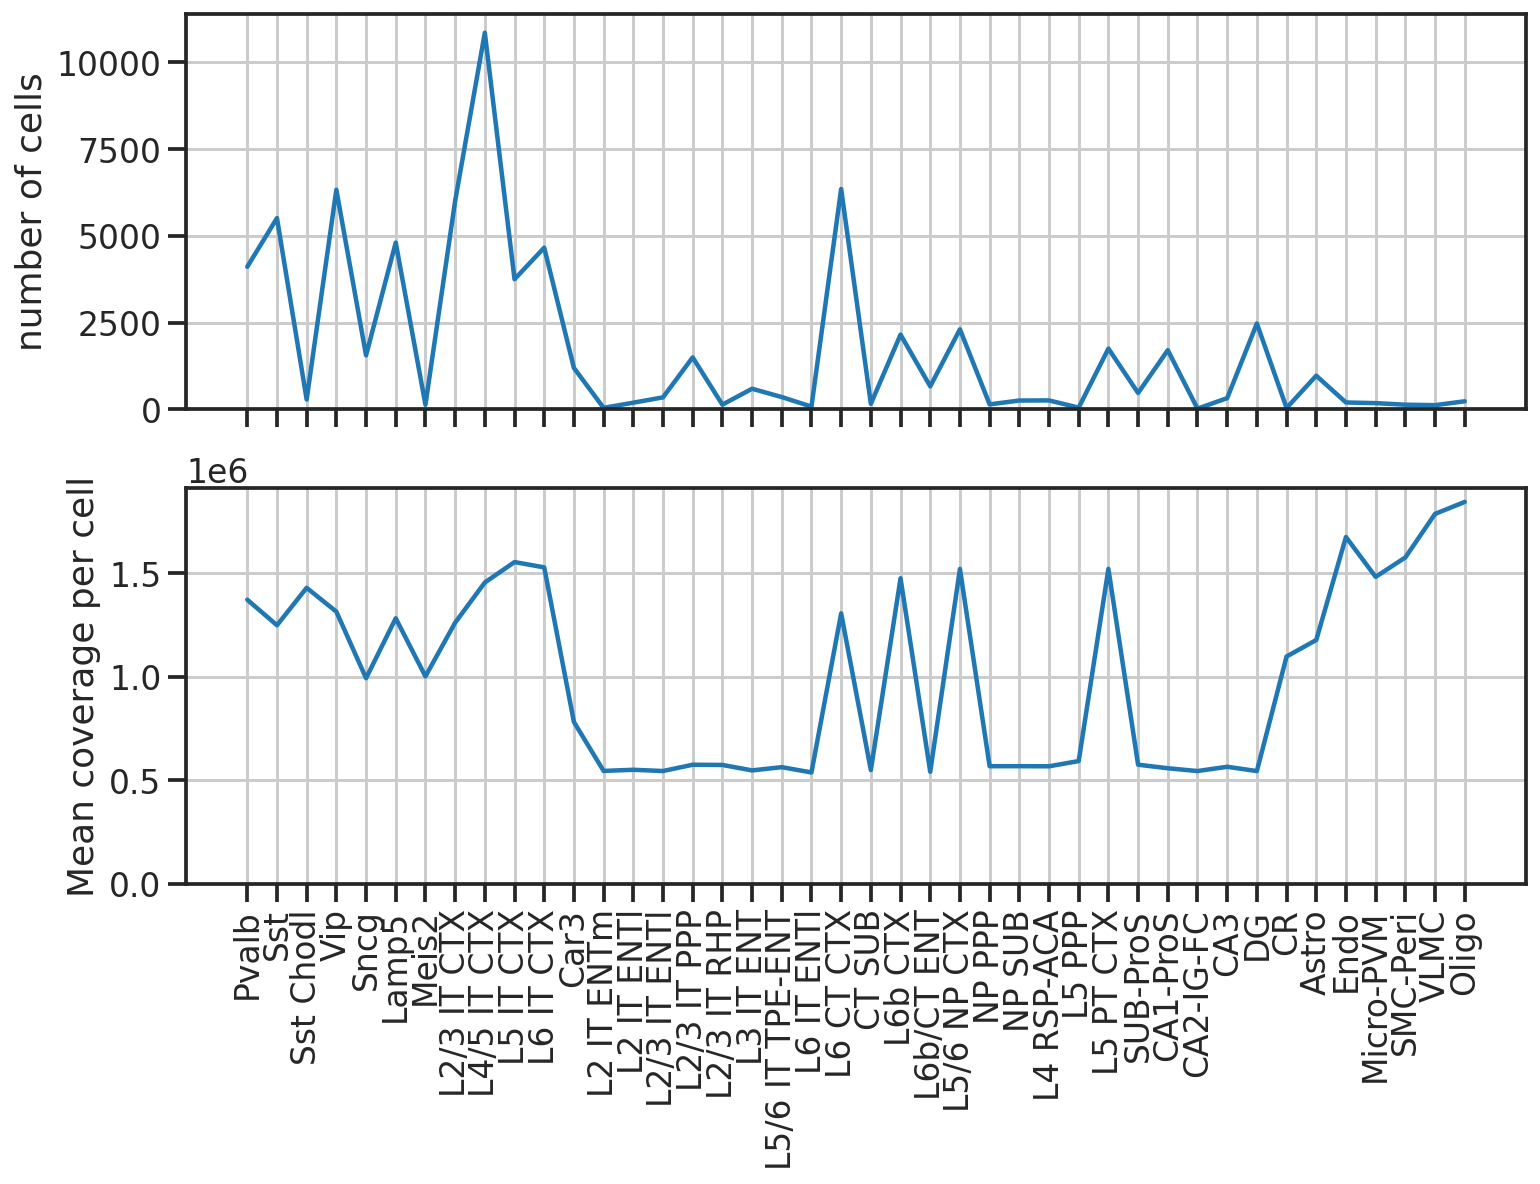

In [10]:
fig, axs = plt.subplots(2,1,figsize=(12,4*2), sharex=True)
ax = axs[0]
ax.plot(cellcount_bytype)
ax.set_ylim(ymin=0)
ax.set_xticklabels(cellcount_bytype.index.values, rotation=90)
ax.set_ylabel('number of cells')

ax = axs[1]
ax.plot(cellcov_bytype)
ax.set_ylim(ymin=0)
ax.set_xticklabels(cellcov_bytype.index.values, rotation=90)
ax.set_ylabel('Mean coverage per cell')

plt.show()

# Generate matrices 

In [25]:

setting_list = []
# for mu in ['0', '1e-04', '0.01', '1', '100', '10000']:
for mu in ['1e-04', '0.01', '1', '100', '10000']:
    study = f'all; DPNMF mu{mu}'
    cell_file = 'smrt_X_all_cells.csv'
    s_file = f'smrt_X_all_y_L3_dpnmfS_k24_mu{mu}.csv'
    w_file = f'smrt_X_all_y_L3_dpnmfW_k24_mu{mu}.csv'
    
    ssel_file = f'smrt_X_all_y_L3_dpnmfSsel_k24_mu{mu}.csv'
    wsel_file = f'smrt_X_all_y_L3_dpnmfWsel_k24_mu{mu}.csv'
    
    setting_list.append((
        study, cell_file, s_file, w_file, ssel_file, wsel_file,
    ))

In [12]:
results = {}

In [31]:
for setting in setting_list:
    ti = time.time()
    
    study, cell_file, s_file, w_file, ssel_file, wsel_file = setting
    #### data =====
    # get DPNMF results
    f = os.path.join(ddir, s_file)
    S = pd.read_csv(f, index_col=0)
    f = os.path.join(ddir, ssel_file)
    Ssel = pd.read_csv(f, index_col=0)

    f = os.path.join(ddir, w_file)
    W = pd.read_csv(f, index_col=0)
    f = os.path.join(ddir, wsel_file)
    Wsel = pd.read_csv(f, index_col=0)
    print(W.columns)
    
    # missed col
    dropped = [col for col in S if col not in Ssel]

    f = os.path.join(ddir, cell_file)
    cells = pd.read_csv(f, index_col=0)['0'].values
    print(S.shape, W.shape, cells.shape)

    # get annotations
    genes = nn_genes

    # get the data right
    adatasub = adata[cells, genes]
    cells_annot = adatasub.obs
    # print(f"{time.time()-ti:.2f}s")
    #### data =====

    # basis matrix
    Wn2, Wn_slim2, Wn_nzcond2 = normalize_w(W)
    Wn, Wn_slim, Wn_nzcond = normalize_w_v2(W, cnstrnts, num_tp=90000)

    # score matrix (theory)
    Sc, clsts = basicu.group_mean(S, cells_annot['subclass_label'].values, 
                                 group_order=l3clst_order)
    Scn = basicu.zscore(Sc, allow_nan=False, axis=0)

    # score matrix (corrected)
    Sp = adatasub.X.toarray().dot(Wn)
    Spc, clsts = basicu.group_mean(Sp, cells_annot['subclass_label'].values, 
                                  group_order=l3clst_order)
    Spcn = basicu.zscore(Spc, allow_nan=False, axis=0)
    # print(f"{time.time()-ti:.2f}s")
    
    # basis order (take quite long)
    Spcn_bo, _, basis_order = basicu.diag_matrix_cols(Spcn) # this takes quite long
    
    
    results[study] = {}
    results[study]['dropped'] = dropped
    results[study]['S'] = S 
    results[study]['Sp'] = Sp
    
    results[study]['Sc'] = Sc
    results[study]['Spc'] = Spc
    
    results[study]['W'] = W
    results[study]['Wn'] = Wn
    results[study]['Wn2'] = Wn2
    results[study]['basis_order'] = basis_order
    
    # break
    


Index(['Basis1', 'Basis2', 'Basis3', 'Basis4', 'Basis5', 'Basis6', 'Basis7',
       'Basis8', 'Basis9', 'Basis10', 'Basis11', 'Basis12', 'Basis13',
       'Basis14', 'Basis15', 'Basis16', 'Basis17', 'Basis18', 'Basis19',
       'Basis20', 'Basis21', 'Basis22', 'Basis23', 'Basis24'],
      dtype='object')
(73347, 24) (10861, 24) (73347,)
Total num probes: 88,317
Total num genes: 7,137
Total num probes: 76,744
Total num genes: 7,131
Index(['Basis1', 'Basis2', 'Basis3', 'Basis4', 'Basis5', 'Basis6', 'Basis7',
       'Basis8', 'Basis9', 'Basis10', 'Basis11', 'Basis12', 'Basis13',
       'Basis14', 'Basis15', 'Basis16', 'Basis17', 'Basis18', 'Basis19',
       'Basis20', 'Basis21', 'Basis22', 'Basis23', 'Basis24'],
      dtype='object')
(73347, 24) (10861, 24) (73347,)
Total num probes: 88,431
Total num genes: 7,171
Total num probes: 77,605
Total num genes: 7,165
Index(['Basis1', 'Basis2', 'Basis3', 'Basis4', 'Basis5', 'Basis6', 'Basis7',
       'Basis8', 'Basis9', 'Basis10', 'Basis11', 'Bas

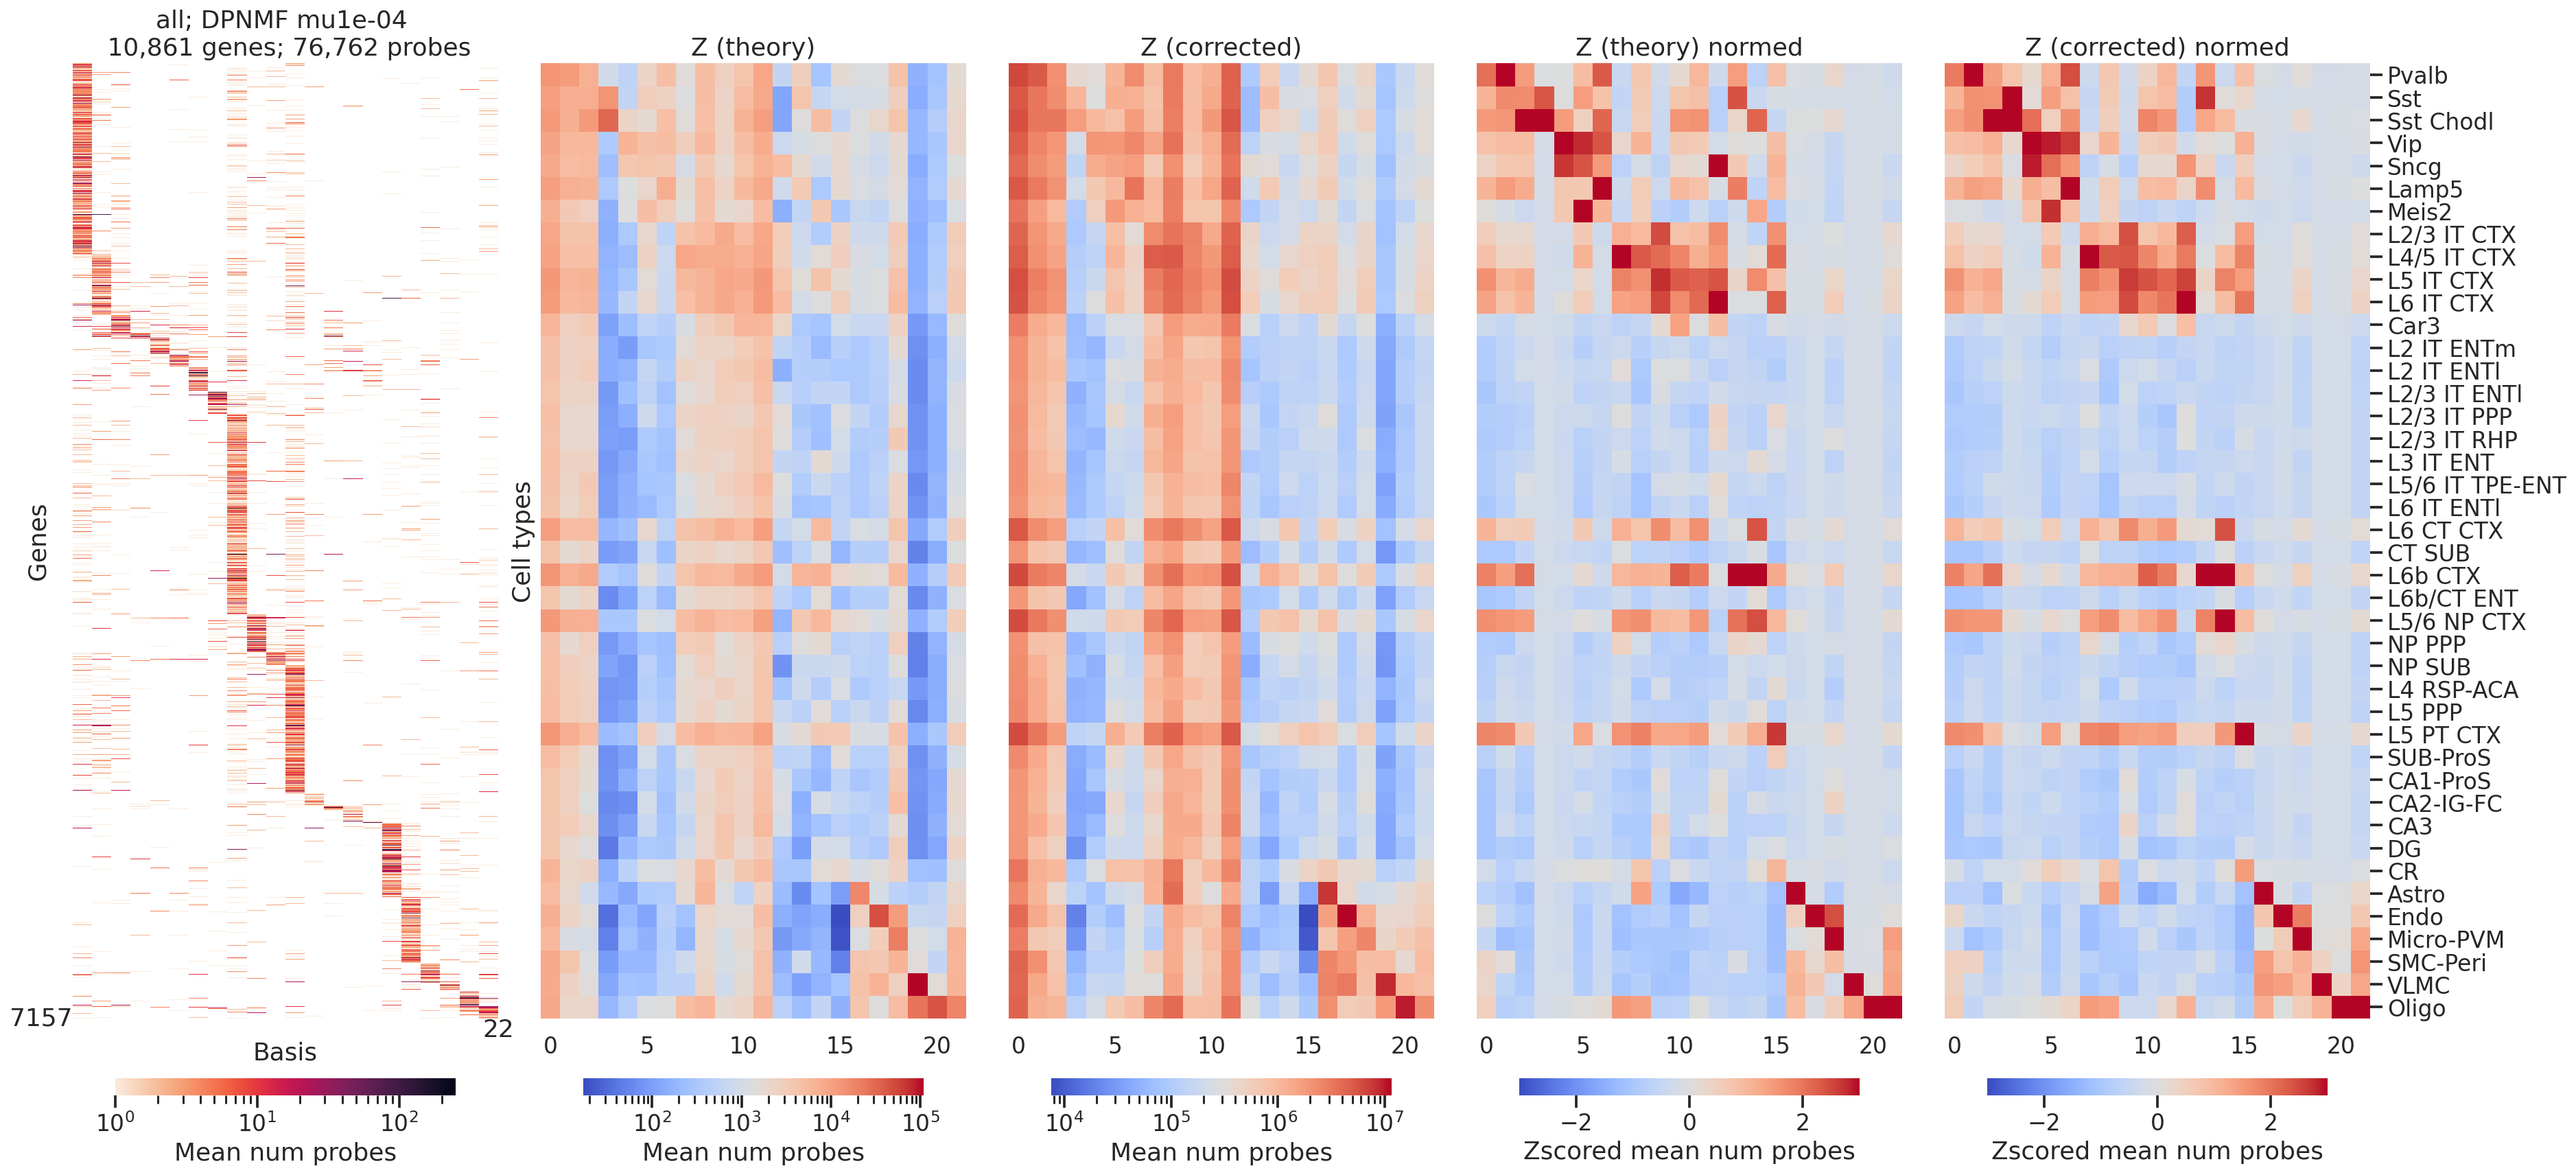

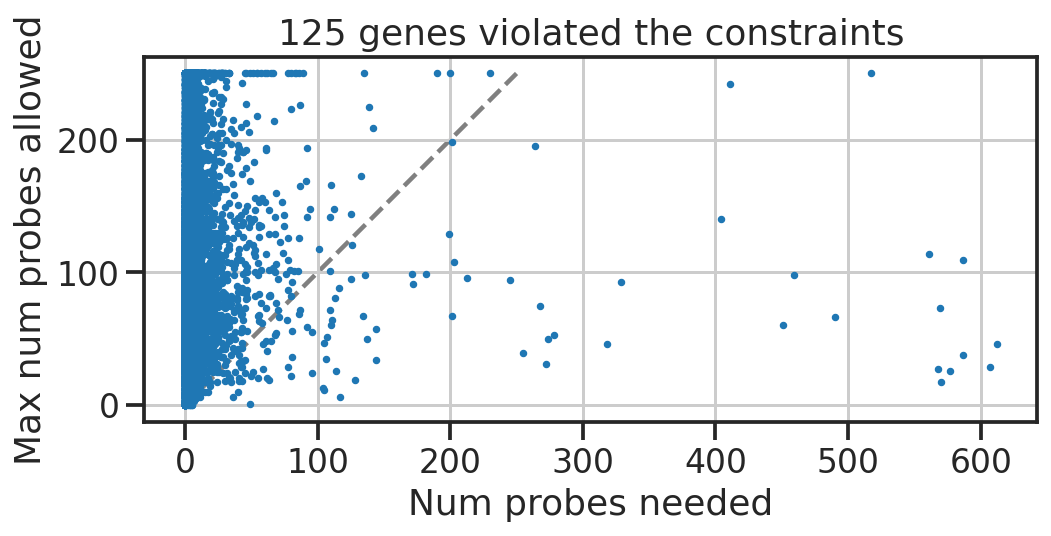

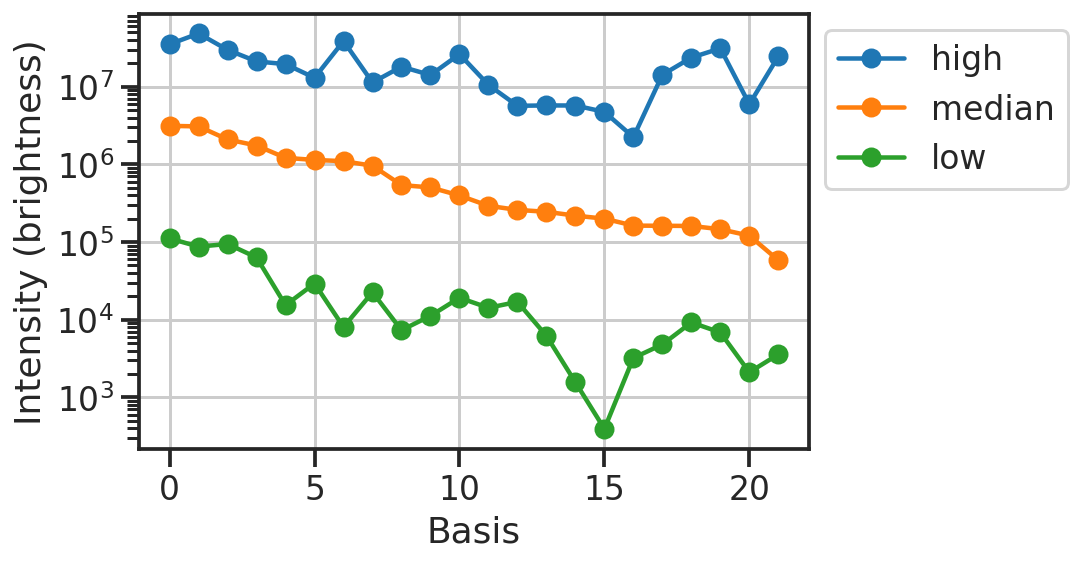

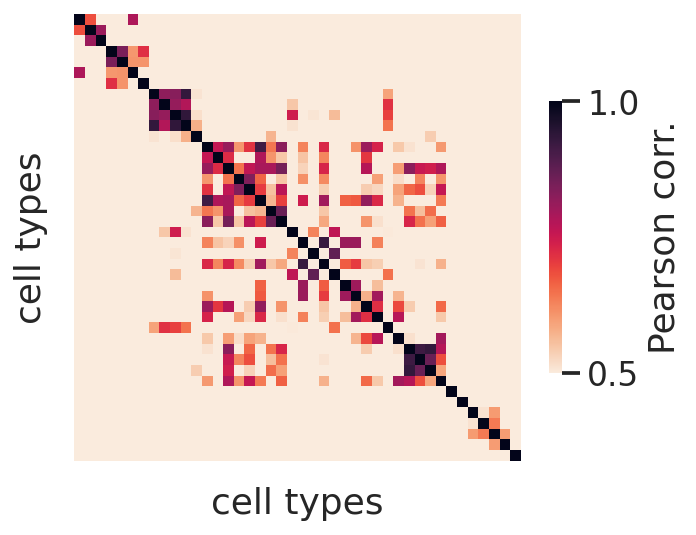

In [14]:
for study, res in results.items():
    Wn = res['Wn']
    Wn2 = res['Wn2']
    Sp = res['Sp']
    Sc = res['Sc']
    Spc = res['Spc']
    basis_order = res['basis_order']
    
    Wn_slim_bo = Wn[Wn.sum(axis=1)>0].iloc[:,basis_order]
    Sc_bo = Sc[:,basis_order]
    Spc_bo = Spc[:,basis_order]
    Scn_bo = basicu.zscore(Sc_bo, axis=0)
    Spcn_bo = basicu.zscore(Spc_bo, axis=0)
    
    corr = np.corrcoef(Spcn_bo)
    
    # Viz
    title = f"{study} \n {len(genes):,} genes; {Wn.sum().sum():,} probes"
    plot_all_mats(Wn_slim_bo, Sc_bo, Spc_bo, Scn_bo, Spcn_bo, title=title)
    # print(f"{time.time()-ti:.2f}s")
    # break
    
    # violation
    fig, ax = plt.subplots(figsize=(8,8))
    needed = Wn2.max(axis=1).values
    ax.scatter(
        needed,
        cnstrnts,
        s=5,
    )
    num_violated = np.sum(cnstrnts < needed)
    ax.plot([0,250], [0, 250], '--', color='gray', zorder=0)
    ax.set_aspect('equal')
    ax.set_ylabel('Max num probes allowed')
    ax.set_xlabel('Num probes needed')
    ax.set_title(f'{num_violated} genes violated the constraints')
    plt.show()
    
    # brightness
    med_intnst = np.median(Sp, axis=0)
    low_intnst = np.min(Sp, axis=0)
    high_intnst = np.max(Sp, axis=0)
    order = np.argsort(med_intnst)[::-1]

    fig, ax = plt.subplots()
    ax.plot(high_intnst[order], '-o', label='high')
    ax.plot(med_intnst[order], '-o', label='median')
    ax.plot(low_intnst[order], '-o', label='low')
    ax.set_xlabel('Basis')
    ax.set_ylabel('Intensity (brightness)')
    ax.set_yscale('log')
    ax.legend(bbox_to_anchor=(1,1))
    plt.show()
    
    # correlation
    vmin = 0.5
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(pd.DataFrame(corr, columns=l3clst_order, index=l3clst_order), 
                yticklabels=False,
                xticklabels=False,
                vmin=vmin, cmap='rocket_r', 
                cbar_kws=dict(shrink=0.5, ticks=[vmin, 1], label='Pearson corr.'),
                ax=ax)
    ax.set_aspect('equal')
    ax.set_xlabel('cell types')
    ax.set_ylabel('cell types')
    plt.show()
    
    break

In [15]:

def plot_Scn(Scn, ax, style='v', **kwargs):    
    """
    """
    m, n = Scn.shape
    
    if style == 'v':
        cbar_kws = dict(shrink=0.5, label='Zscored mean num probes')
    elif style == 'h':
        cbar_kws = dict(shrink=0.8, label='Zscored mean num probes', orientation='horizontal', pad=0.05)
        
    sns.heatmap(Scn, 
                xticklabels=5,
                cmap='coolwarm', 
                cbar_kws=cbar_kws,
                center=0,
                vmax=3,
                vmin=-3,
                ax=ax,
                **kwargs,
               )

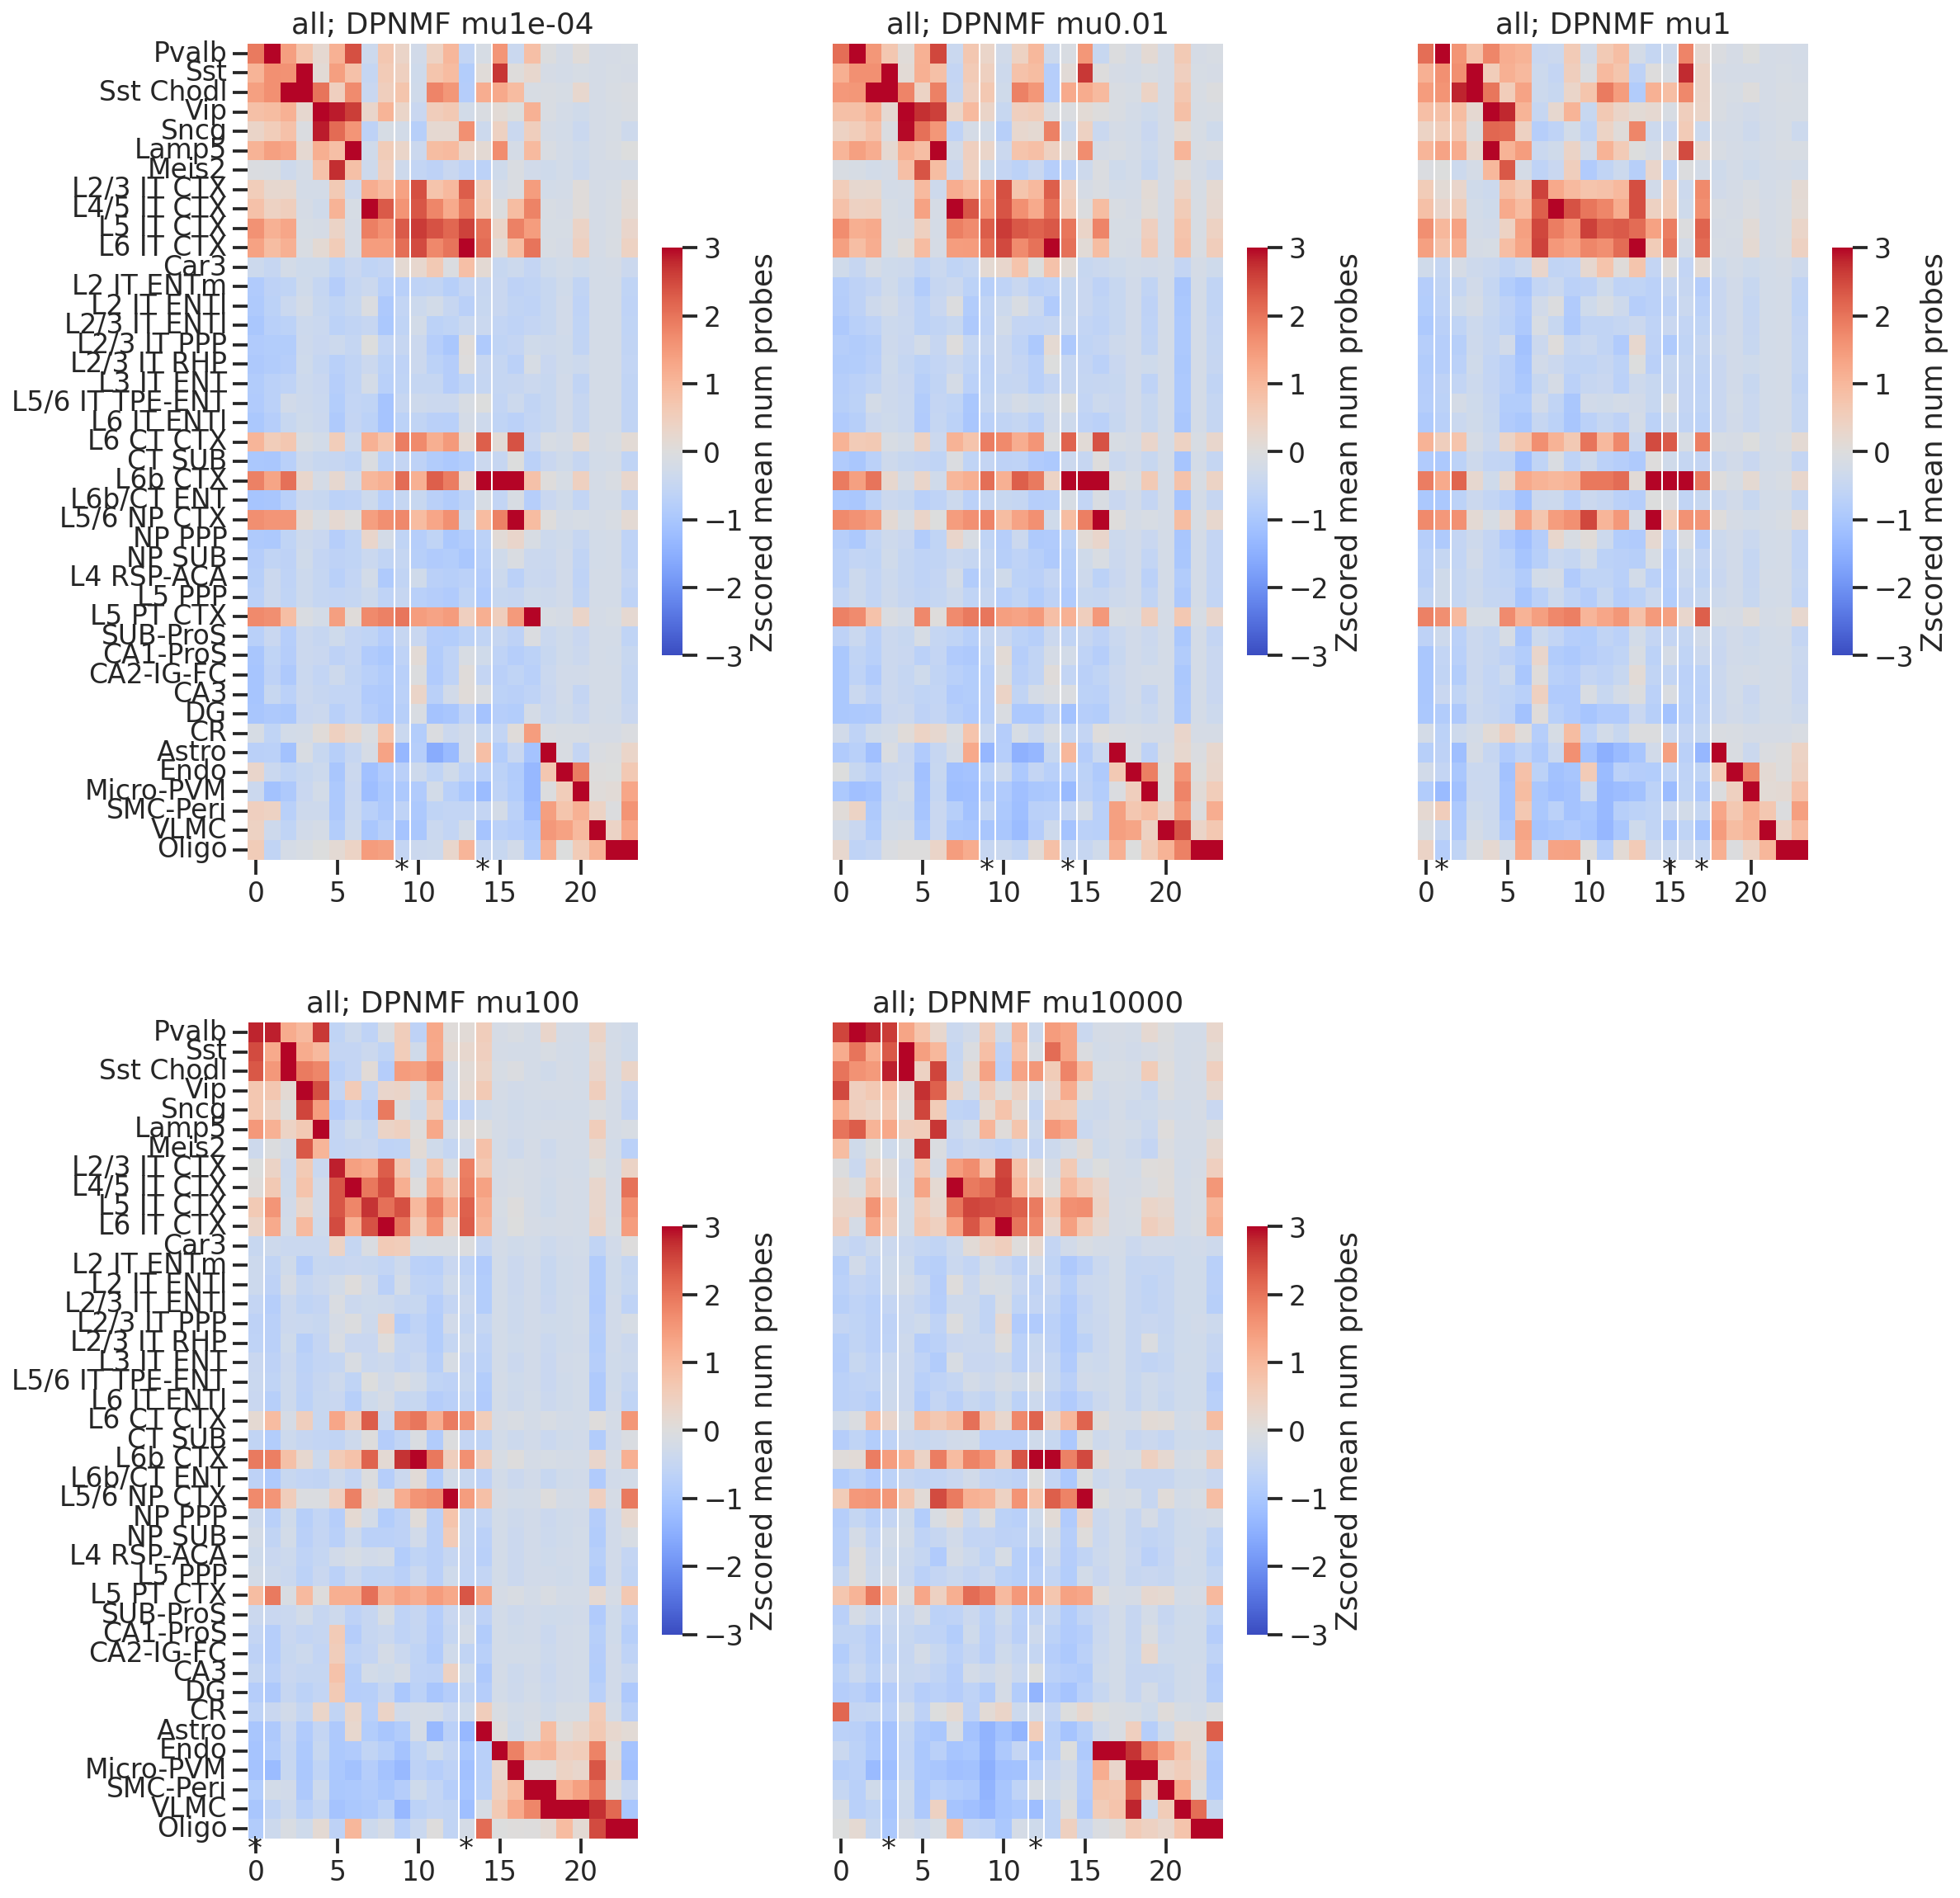

In [59]:
# check scores
ncases = len(results)
nx = 3
ny = 2

fig, axs = plt.subplots(ny, nx, figsize=(6*nx,10*ny))
# cbar_ax = fig.add_axes([0.92,0.2,0.01,0.6])
for i, (study, res) in enumerate(results.items()):
    ax = axs.flat[i]
    
    # correlation
    Spc = res['Spc']
    basis_order = res['basis_order']
    Spcn = basicu.zscore(Spc, axis=0)[:,basis_order]
    
    dropped = res['dropped']
    marks = [int(basis[len('Basis'):])-1 for basis in dropped]
    markticks = basicu.get_index_from_array(basis_order, marks)
    
    if i in [0,3]:
        plot_Scn(Spcn, ax, style='v', yticklabels=l3clst_order)
    else:
        plot_Scn(Spcn, ax, style='v', yticklabels=[])
    ax.set_title(study)
    
    ax.vlines(markticks, 0, len(Spc), color='white', linewidth=1)
    ax.vlines(markticks+1, 0, len(Spc), color='white', linewidth=1)
    for tick in markticks:
        ax.text(tick, len(Spc)+1, '*')
    
for ax in axs.flat[i+1:]:
    ax.axis('off')
plt.show()


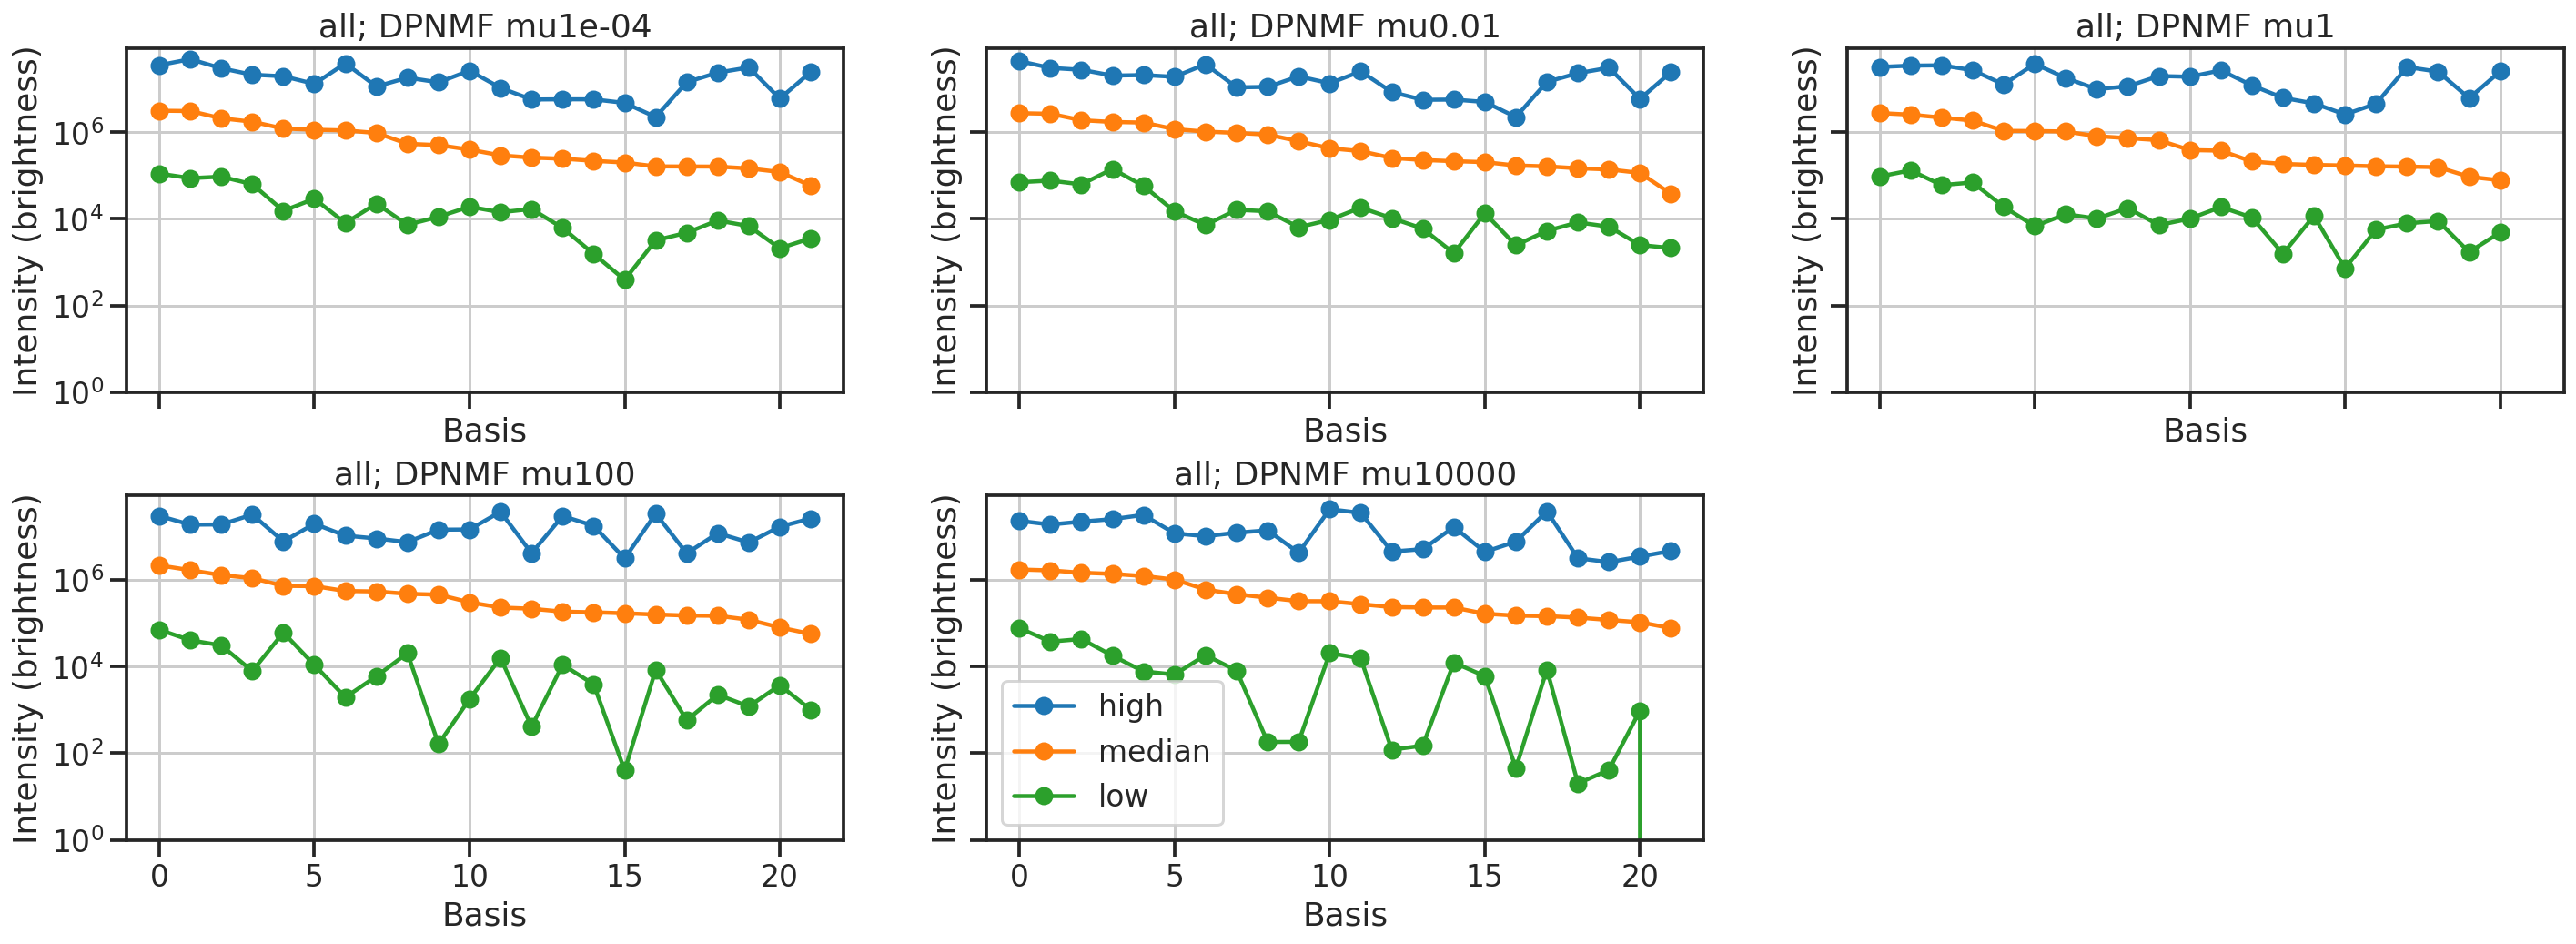

In [17]:
# check brightness
ncases = len(results)
nx = 3
ny = 2

fig, axs = plt.subplots(ny, nx, figsize=(8*nx,4*ny), sharex=True, sharey=True)
# cbar_ax = fig.add_axes([0.92,0.2,0.01,0.6])
for i, (study, res) in enumerate(results.items()):
    ax = axs.flat[i]
    
    # correlation
    Sp = res['Sp']
    # brightness
    med_intnst = np.median(Sp, axis=0)
    low_intnst = np.min(Sp, axis=0)
    high_intnst = np.max(Sp, axis=0)
    order = np.argsort(med_intnst)[::-1]

    ax.plot(high_intnst[order], '-o', label='high')
    ax.plot(med_intnst[order], '-o', label='median')
    ax.plot(low_intnst[order], '-o', label='low')
    ax.set_xlabel('Basis')
    ax.set_ylabel('Intensity (brightness)')
    ax.set_yscale('log')
    ax.set_title(study)
    ax.set_ylim(ymin=1e0)
    
ax.legend()
for ax in axs.flat[i+1:]:
    ax.axis('off')
    
fig.subplots_adjust(hspace=0.3)
plt.show()



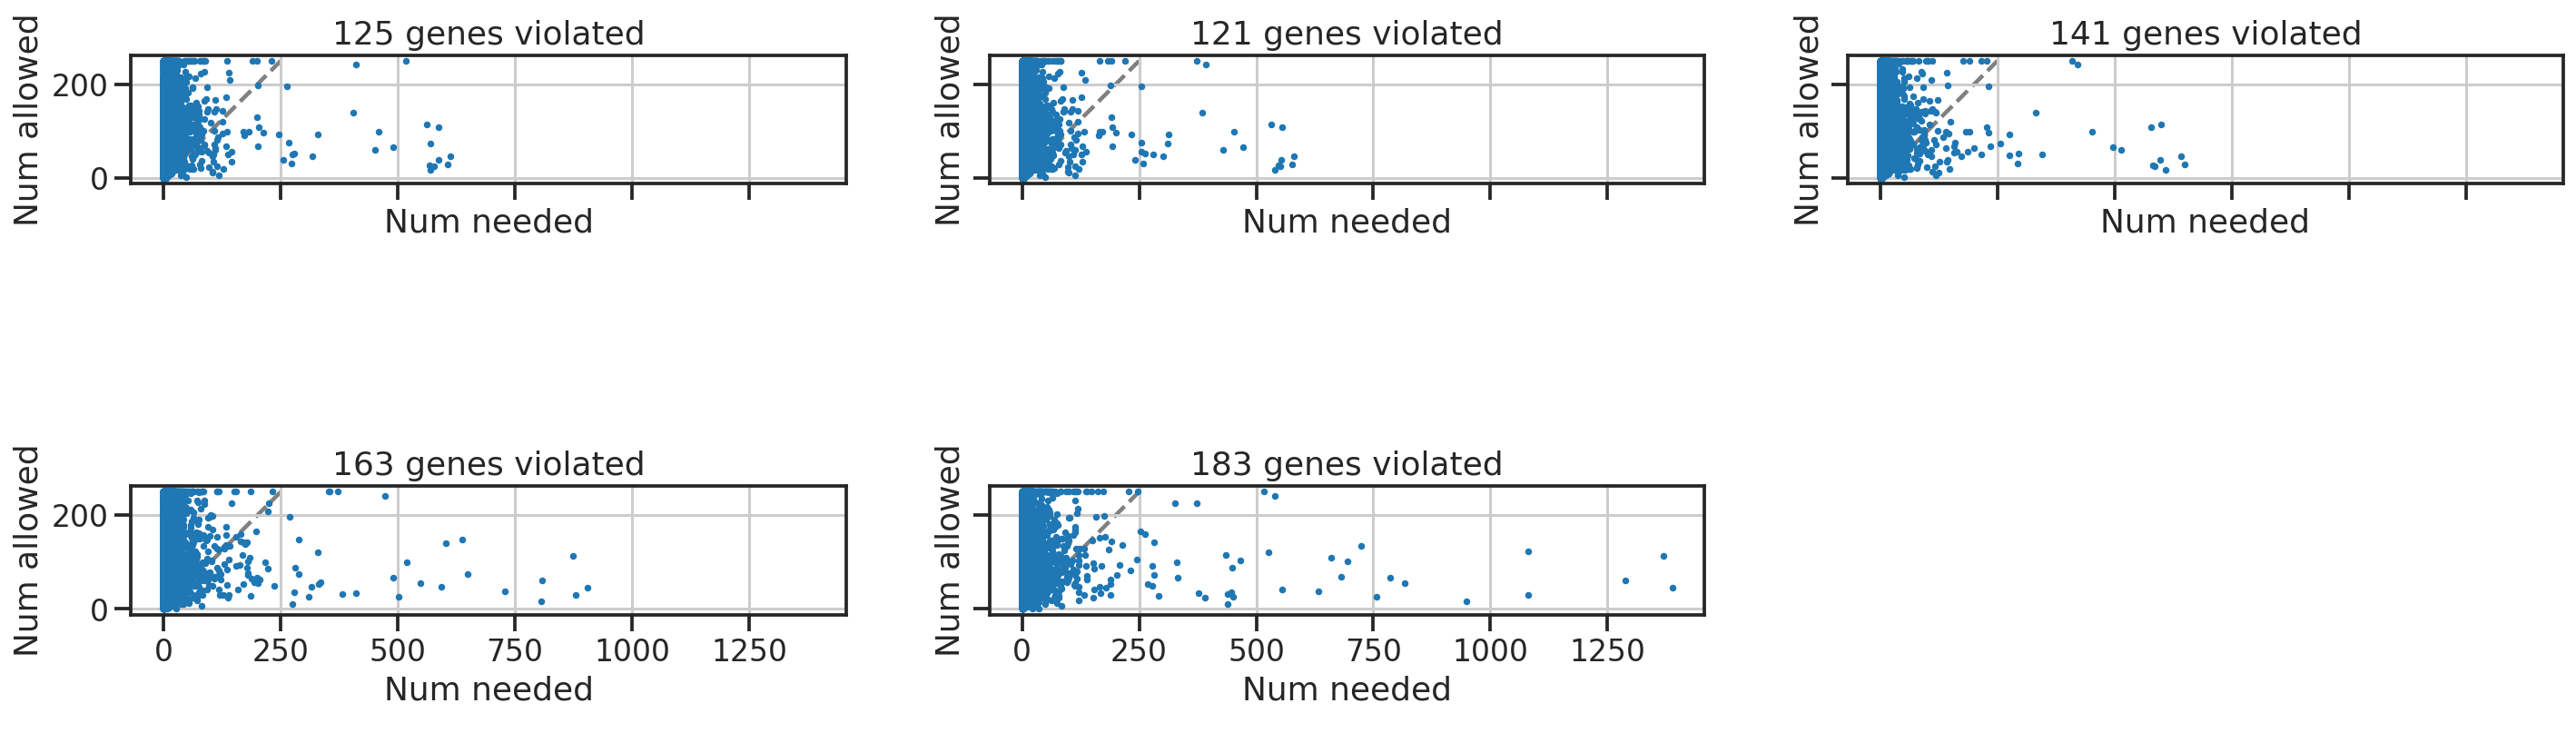

In [19]:
# check genes violated
ncases = len(results)
nx = 3
ny = 2

fig, axs = plt.subplots(ny, nx, figsize=(8*nx,4*ny), sharex=True, sharey=True)
# cbar_ax = fig.add_axes([0.92,0.2,0.01,0.6])
for i, (study, res) in enumerate(results.items()):
    ax = axs.flat[i]
    
    Wn2 = res['Wn2']
    # violation
    needed = Wn2.max(axis=1).values
    ax.scatter(
        needed,
        cnstrnts,
        s=5,
    )
    num_violated = np.sum(cnstrnts < needed)
    ax.plot([0,250], [0, 250], '--', color='gray', zorder=0)
    ax.set_aspect('equal')
    ax.set_ylabel('Num allowed')
    ax.set_xlabel('Num needed')
    ax.set_title(f'{num_violated} genes violated')
    
for ax in axs.flat[i+1:]:
    ax.axis('off')
plt.show()


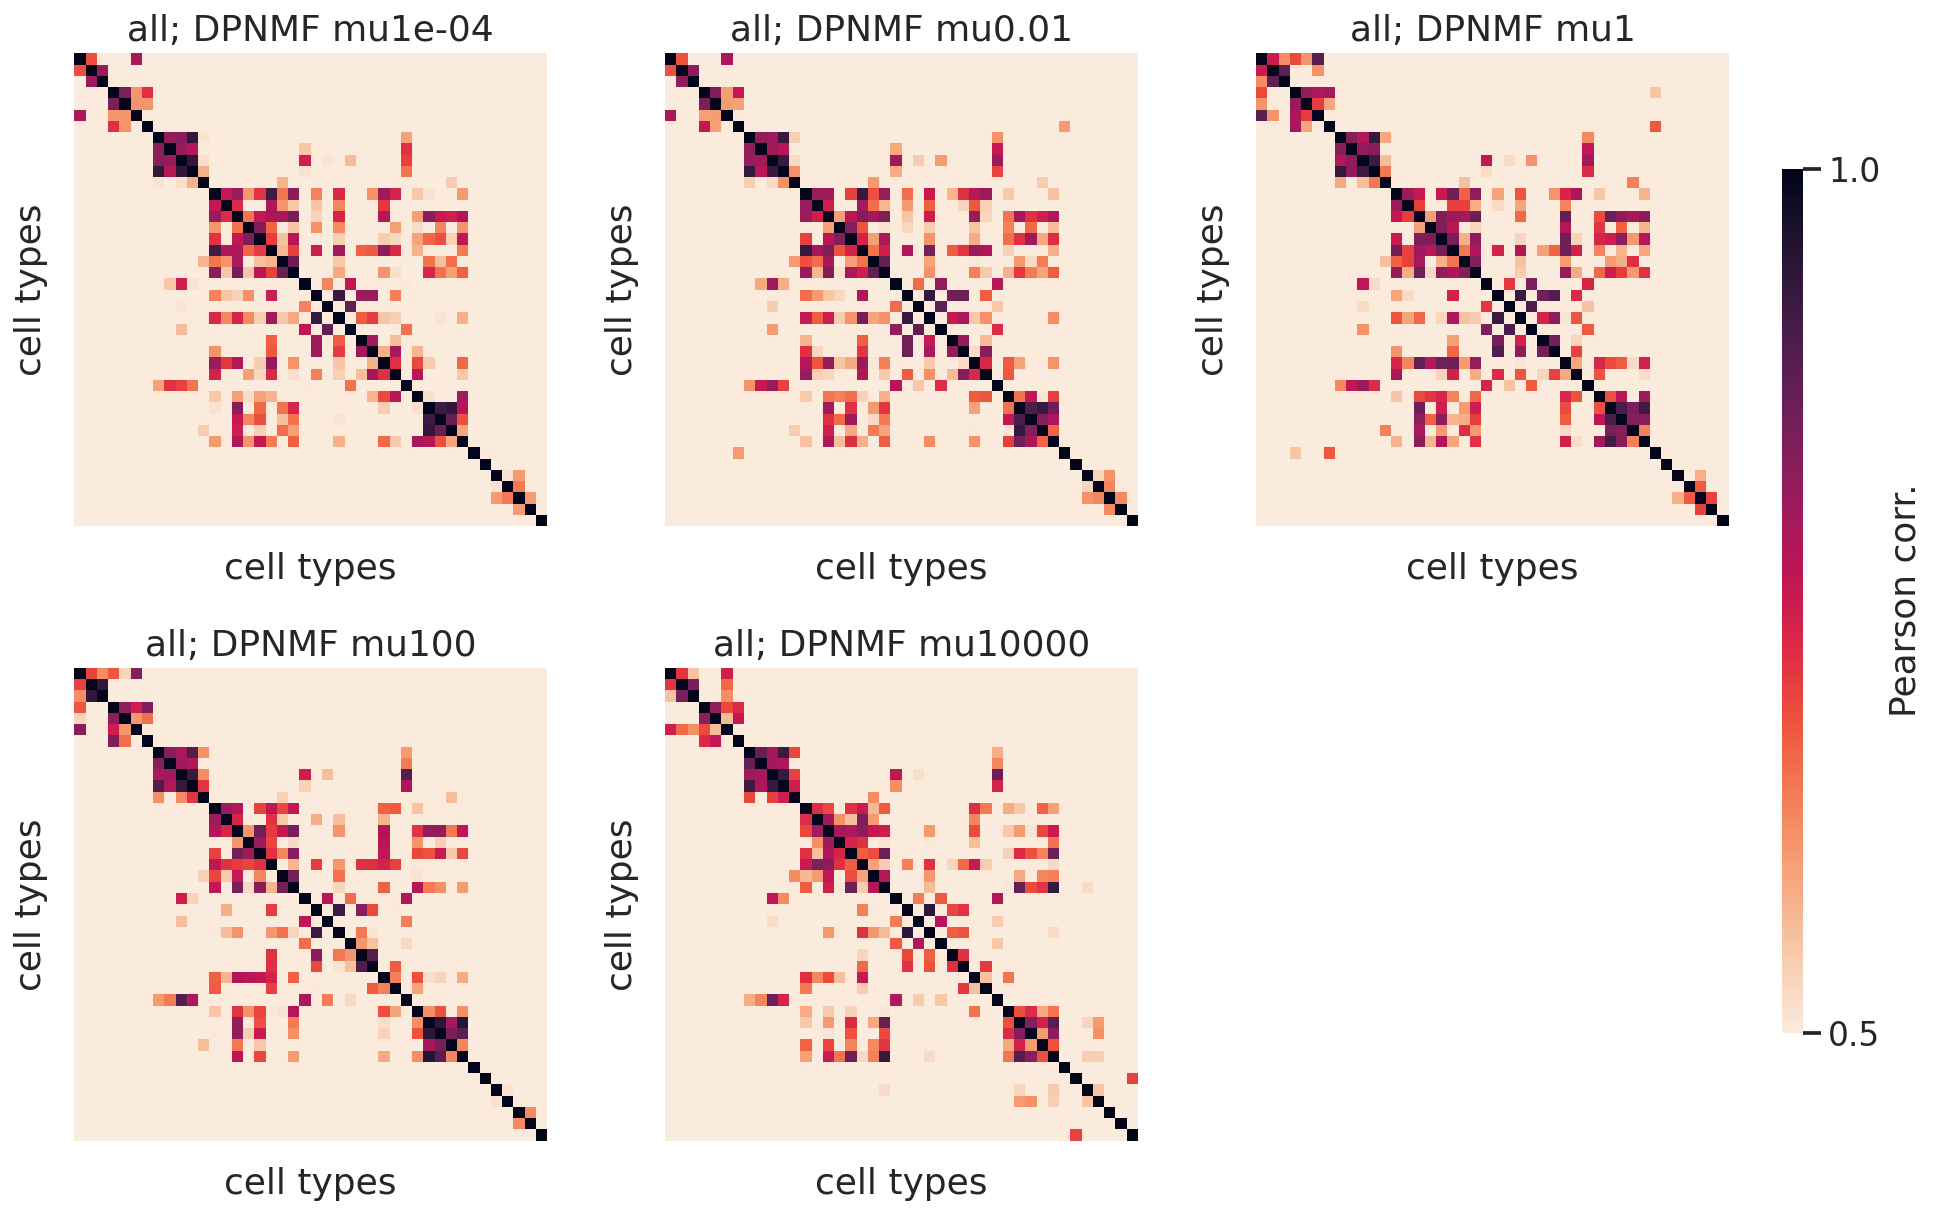

In [20]:
# check correlations 
ncases = len(results)
nx = 3
ny = 2

fig, axs = plt.subplots(ny, nx, figsize=(5*nx,5*ny))
cbar_ax = fig.add_axes([0.92,0.2,0.01,0.6])
for i, (study, res) in enumerate(results.items()):
    ax = axs.flat[i]
    
    # correlation
    Spc = res['Spc']
    Spcn = basicu.zscore(Spc, axis=0)
    corr = np.corrcoef(Spcn)
    
    vmin = 0.5
    if i == ncases-1:
        cbar = True
    else:
        cbar = False
    sns.heatmap(pd.DataFrame(corr, columns=l3clst_order, index=l3clst_order), 
                yticklabels=False,
                xticklabels=False,
                vmin=vmin, cmap='rocket_r', 
                cbar_kws=dict(shrink=0.5, ticks=[vmin, 1], label='Pearson corr.'),
                cbar=cbar,
                cbar_ax=cbar_ax,
                ax=ax)
    
    ax.set_aspect('equal')
    ax.set_xlabel('cell types')
    ax.set_ylabel('cell types')
    ax.set_title(study)
    
for ax in axs.flat[i+1:]:
    ax.axis('off')
fig.subplots_adjust(hspace=0.3)
plt.show()

In [21]:
colors = sns.color_palette(palette="Set2", n_colors=5)
colors

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)]

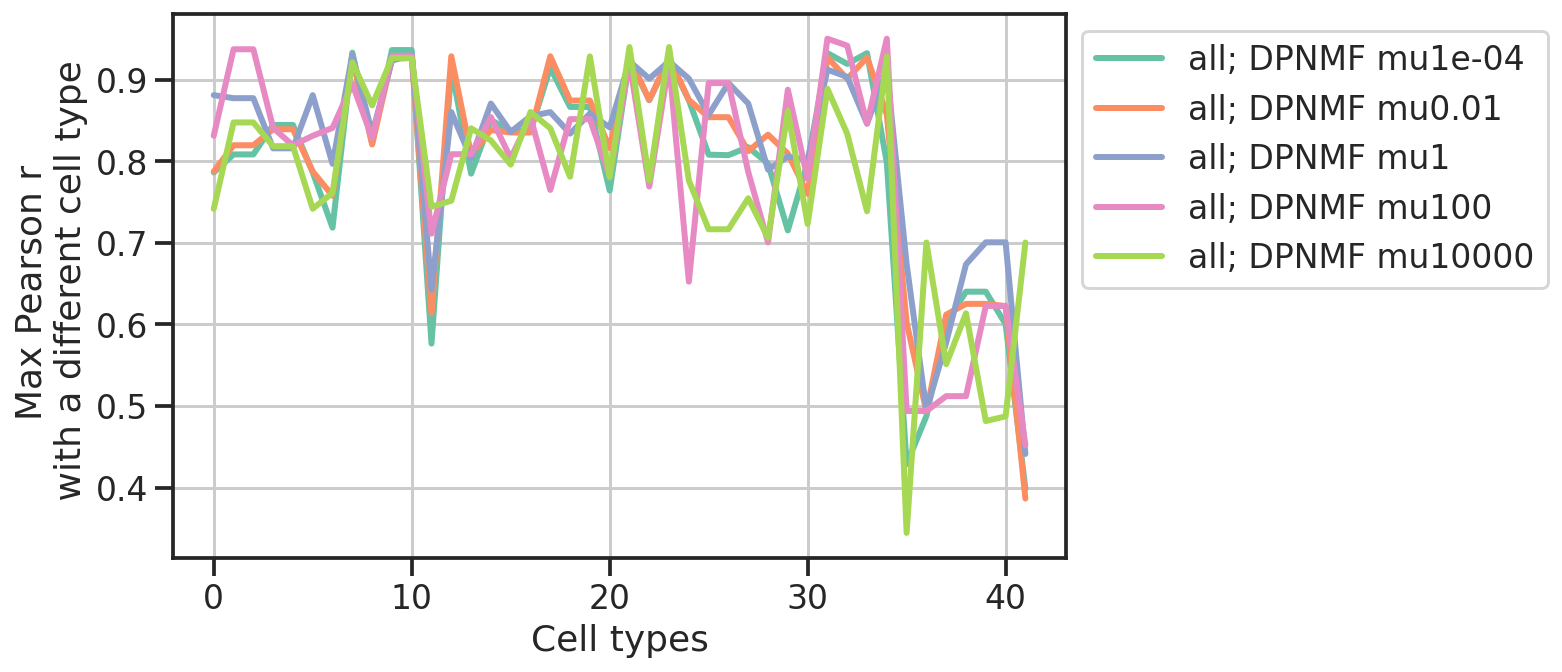

In [22]:
# check correlations 
ncases = len(results)

fig, ax = plt.subplots(figsize=(8,5))
for i, (study, res) in enumerate(results.items()):
    # ax = axs.flat[i]
    # correlation
    Spc = res['Spc']
    Spcn = basicu.zscore(Spc, axis=0)
    corr = np.corrcoef(Spcn)
    corr_maxneighbor = np.sort(corr, axis=0)[-2,:]
    ax.plot(corr_maxneighbor, '-', label=study, alpha=1, color=colors[i], linewidth=3)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Cell types')
ax.set_ylabel('Max Pearson r \n with a different cell type')
plt.show()

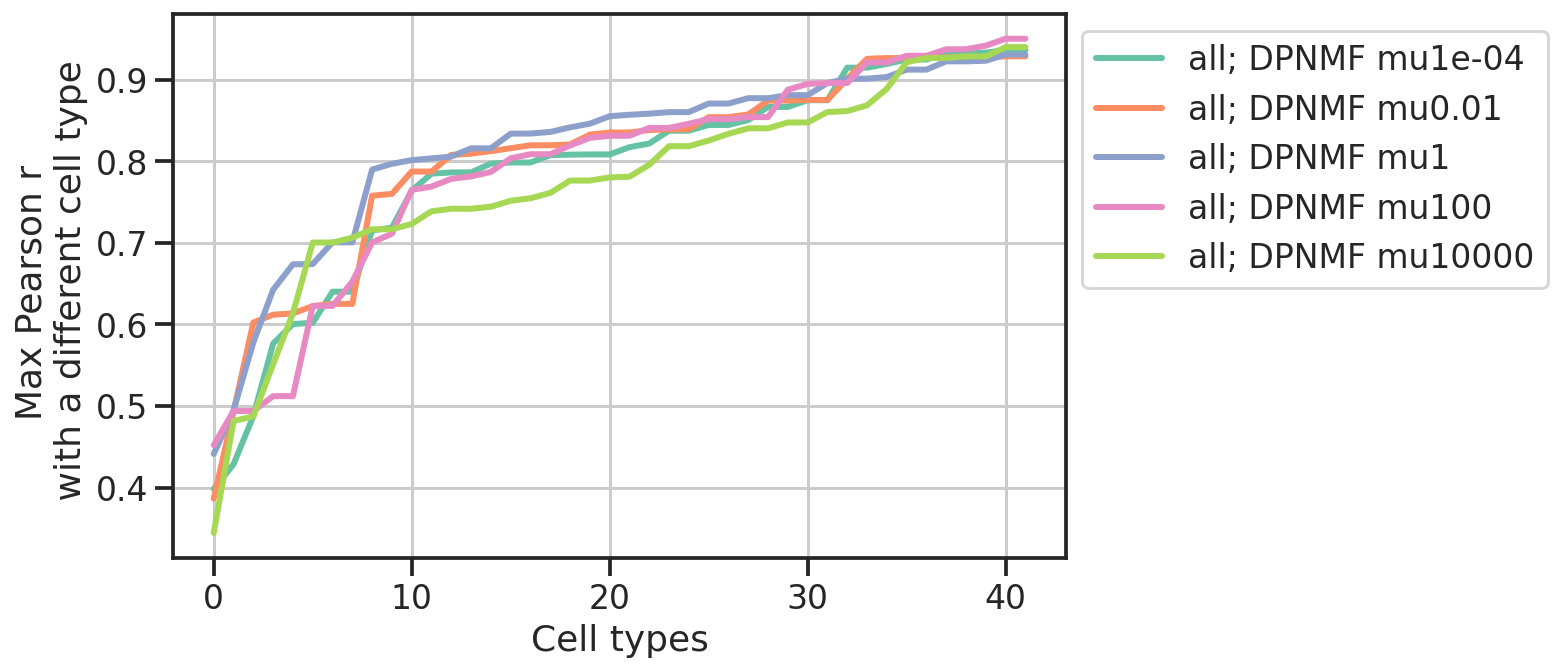

In [23]:
# check correlations 
ncases = len(results)

fig, ax = plt.subplots(figsize=(8,5))
for i, (study, res) in enumerate(results.items()):
    # ax = axs.flat[i]
    # correlation
    Spc = res['Spc']
    Spcn = basicu.zscore(Spc, axis=0)
    corr = np.corrcoef(Spcn)
    corr_maxneighbor = np.sort(corr, axis=0)[-2,:]
    ax.plot(np.sort(corr_maxneighbor), '-', label=study, alpha=1, color=colors[i], linewidth=3)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Cell types')
ax.set_ylabel('Max Pearson r \n with a different cell type')
plt.show()